# Towards DeepLearning from Scratch with Titatic

## Get the Titanic dataset from Kaggle

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: 
    path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile
        import kaggle
        
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [2]:
# Display what we have inside the titanic folder
!ls {path}

gender_submission.csv  test.csv  train.csv


In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Binary classification problem with Survived column as target

## Data Exploration

In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [6]:
df.Age.mode()

0    24.0
Name: Age, dtype: float64

## Filling missing value, mode inputing

Mode can have more than one value so we just localize the first one

In [7]:
df.fillna(modes, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S


In [8]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [9]:
df.describe(include=[np.number])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
df.describe(include=[np.object_])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


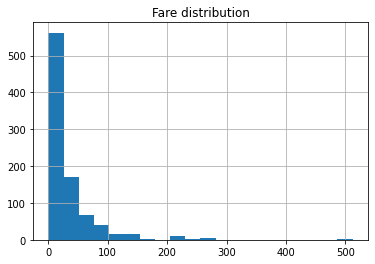

In [11]:
df.Fare.hist(bins=20);
plt.title("Fare distribution");

Linear Models and NN suffers when we feed them long tail distributions, we should try to help making the distribution look better

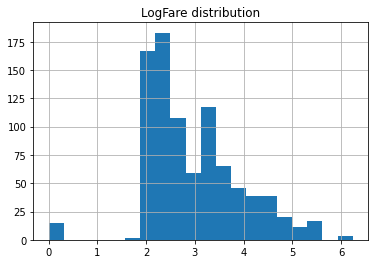

In [12]:
df['LogFare'] = np.log(1 + df.Fare)
df.LogFare.hist(bins=20);
plt.title("LogFare distribution");

# Get dummies cols for categorical columns

In [13]:
# I will avoid using Name, it's useful but out of scope for this nb
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [14]:
added_cols = ['Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols]

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1,0,0,1
1,1,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,0,1,0,0,0,0,1
4,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...
886,0,1,0,1,0,0,0,1
887,1,0,1,0,0,0,0,1
888,1,0,0,0,1,0,0,1
889,0,1,1,0,0,1,0,0


In [15]:
y = torch.tensor(df.Survived)
y

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 

In [16]:
features_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
X = torch.tensor(df[features_cols].values, dtype=torch.float)
X

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [17]:
vals, idx = X.max(axis=0)
X = X/vals
X

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

In [18]:
X.shape, y.shape

(torch.Size([891, 12]), torch.Size([891]))

## Linear Model

In [19]:
torch.manual_seed(442)

n_coeffs = X.shape[1]
coeffs = torch.rand(n_coeffs) - 0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [20]:
preds = (X*coeffs).sum(axis=1)
preds[:10]

tensor([ 0.1412, -0.5725,  0.1494,  0.2571,  0.0453, -0.0448,  0.0792,  0.2961,  0.2128, -0.5770])

# Loss Function MAE

In [21]:
def mae(preds, actuals):
    return torch.abs(preds - actuals).mean()

In [22]:
mae(preds, y)

tensor(0.5200)

In [23]:
def calc_preds(X, coeffs):
    return (X*coeffs).sum(axis=1)

def calc_loss(X, coeffs, actuals):
    preds = calc_preds(X, coeffs)
    return mae(preds, actuals)

## One step SGD

In [24]:
coeffs.requires_grad_()
loss = calc_loss(X, coeffs, y)
loss.backward()
with torch.no_grad():
    coeffs.sub_(0.01*coeffs.grad)
    coeffs.grad.zero_()
    print(calc_loss(X, coeffs, y))

tensor(0.5185)


## Training Loop

In [25]:
from fastai.data.transforms import RandomSplitter
trn_idx, val_idx = RandomSplitter(seed=42)(df)
trn_idx, val_idx

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

In [26]:
X_train = X[trn_idx]
X_val = X[val_idx]
y_train = y[trn_idx]
y_val = y[val_idx]
len(X_train),len(X_val)

(713, 178)

In [27]:
def init_coeffs():
    return (torch.rand(n_coeffs) - 0.5).requires_grad_()

In [28]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(lr*coeffs.grad)
    coeffs.grad.zero_()

In [29]:
def one_epoch(coeffs, lr):
    loss = calc_loss(X_train, coeffs, y_train)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [30]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs, lr)
    return coeffs

In [31]:
coeffs = train_model(18, lr=0.2)

0.518; 0.491; 0.468; 0.445; 0.422; 0.400; 0.378; 0.358; 0.340; 0.327; 0.315; 0.306; 0.308; 0.311; 0.311; 0.292; 0.296; 0.287; 

In [32]:
def show_coeffs(): 
    return dict(zip(features_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2581),
 'SibSp': tensor(0.0894),
 'Parch': tensor(0.2346),
 'LogFare': tensor(0.0275),
 'Sex_female': tensor(0.2574),
 'Sex_male': tensor(-0.4129),
 'Pclass_1': tensor(0.7098),
 'Pclass_2': tensor(0.4246),
 'Pclass_3': tensor(0.3691),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2490),
 'Embarked_S': tensor(0.2116)}

## Measuring Accuracy

In [33]:
preds = calc_preds(X_val, coeffs)
preds

tensor([ 0.8650,  0.1373, -0.0164,  0.1843,  0.1544,  0.1385,  0.7599,  0.8149,  0.3157,  0.7087,  0.0742,  0.0368,  0.2162,  0.8077,
         0.0670,  0.3779,  0.3134,  0.8666,  0.1121,  0.7481,  0.1000,  0.3425,  1.0079,  0.8467,  0.1125,  0.1532,  0.8961,  0.3231,
         0.1230,  0.8076,  0.9254,  0.9376,  0.1161,  0.0791,  0.8457,  0.9699,  0.3725,  1.0040,  0.1001,  0.7782,  0.1728,  0.1001,
         0.1984,  0.9786,  0.1130,  0.9177,  0.1018,  0.1515,  0.1369,  0.7764,  0.4462,  0.2899,  0.2770,  0.0963,  0.1503,  0.1309,
         0.1373,  0.0752,  0.1098,  0.0884,  0.3104,  0.1333,  0.2656,  0.1097,  0.7774,  0.4991,  0.1576,  0.0562,  0.1388,  0.7603,
         0.0936,  0.7350,  0.1341,  0.1007,  0.4456,  0.1258,  0.1001,  0.4170,  0.1737,  0.0840,  0.2979,  1.1200,  0.1032,  0.0997,
         0.7431,  0.1325,  0.3662,  1.2441,  0.7126,  0.1608,  0.0744,  0.1001,  0.9865, -0.0358,  0.7943,  0.0027,  0.0895,  0.8345,
         0.8141,  0.1529,  0.1696,  0.8076,  0.0742,  0.0807, 

In [34]:
((preds >= 0.5) == y_val).float().mean()

tensor(0.7978)

In [35]:
def accuracy(preds, actuals):
    return (actuals.bool() == (preds >= 0.5)).float().mean()

In [36]:
accuracy(preds, y_val)

tensor(0.7978)

## Using Sigmoid, boundary (0,1)

In [37]:
def calc_preds(X, coeffs):
    return torch.sigmoid((X*coeffs).sum(axis=1))

In [38]:
coeffs = train_model(18, lr=100)

0.503; 0.326; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 

In [39]:
show_coeffs()

{'Age': tensor(-1.5448),
 'SibSp': tensor(-0.8796),
 'Parch': tensor(-0.2216),
 'LogFare': tensor(0.2277),
 'Sex_female': tensor(8.1222),
 'Sex_male': tensor(-10.3509),
 'Pclass_1': tensor(3.8034),
 'Pclass_2': tensor(1.6793),
 'Pclass_3': tensor(-6.0523),
 'Embarked_C': tensor(1.1899),
 'Embarked_Q': tensor(1.6941),
 'Embarked_S': tensor(-4.4010)}

In [40]:
preds = calc_preds(X_val, coeffs)
preds

tensor([    1.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.9624,     0.9930,     0.0000,     0.9407,     0.0000,
            0.0000,     0.0000,     0.9671,     0.0000,     0.0000,     0.0000,     0.9933,     0.0000,     0.0548,     0.0000,     0.0000,
            1.0000,     0.9884,     0.0000,     0.0000,     0.0827,     0.0000,     0.0000,     0.9671,     0.9938,     0.0422,     0.0000,
            0.0000,     1.0000,     0.0597,     0.0000,     1.0000,     0.0000,     0.0550,     0.0000,     0.0000,     0.0000,     1.0000,
            0.0000,     0.0402,     0.0000,     0.0000,     0.0000,     0.0642,     0.0031,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0030,     0.0000,     0.0000,     0.0000,     0.9897,     0.0000,
            0.0000,     0.0000,     0.0000,     0.9903,     0.0000,     0.9440,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000, 

In [41]:
accuracy(preds, y_val)

tensor(0.8258)

## Submitting to Kaggle

In [42]:
tst_df = pd.read_csv(path/'test.csv')
tst_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [43]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [44]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

X_test = torch.tensor(tst_df[features_cols].values, dtype=torch.float)
X_test = X_test / vals

In [45]:
tst_df['Survived'] = (calc_preds(X_test, coeffs)>0.5).int()

In [46]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [47]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


## Do the same using Matrix Products

In [48]:
(X_val*coeffs).sum(axis=1)

tensor([ 11.1267, -15.0934, -15.5998, -13.2629, -13.4591, -13.7264,   3.2430,   4.9561, -21.3059,   2.7645, -21.3423, -15.7219, -20.9372,
          3.3803, -21.3872, -11.6965, -12.0827,   5.0011, -13.7055,  -2.8468, -21.1879, -11.9089,  12.3877,   4.4427, -21.1143, -15.1648,
         -2.4062, -12.0247, -21.0497,   3.3798,   5.0753,  -3.1224, -21.0913, -21.3128,  11.0109,  -2.7566, -11.7263,  12.8073, -21.1873,
         -2.8439, -13.3504, -21.1873, -13.7311,  12.6563, -21.1100,  -3.1722, -21.1584, -21.2256, -15.0968,  -2.6789,  -5.7583, -21.4604,
        -21.3647, -21.2108, -13.4856, -13.6015, -15.0933, -21.5069, -21.1293, -21.2509,  -5.8143, -21.1663, -12.3680, -21.1298,   4.5611,
        -11.2318, -13.4398, -21.4396, -15.5260,   4.6291, -21.2265,   2.8243, -13.5822, -21.1818, -11.2918, -21.0339, -21.1873, -11.6276,
        -13.3433, -13.8791, -13.2142,  12.6196, -21.1686, -21.1906,   4.5241,  -8.0114,  -5.6436,   7.2455,  10.4582, -13.4205, -21.3405,
        -21.1873,  12.7069, -15.71

In [49]:
X_val@coeffs

tensor([ 11.1267, -15.0934, -15.5998, -13.2629, -13.4591, -13.7264,   3.2430,   4.9561, -21.3059,   2.7645, -21.3423, -15.7219, -20.9372,
          3.3803, -21.3872, -11.6965, -12.0827,   5.0011, -13.7055,  -2.8468, -21.1879, -11.9089,  12.3877,   4.4427, -21.1143, -15.1648,
         -2.4062, -12.0247, -21.0497,   3.3798,   5.0753,  -3.1224, -21.0913, -21.3128,  11.0109,  -2.7566, -11.7263,  12.8073, -21.1873,
         -2.8439, -13.3504, -21.1873, -13.7311,  12.6563, -21.1100,  -3.1722, -21.1584, -21.2256, -15.0968,  -2.6789,  -5.7583, -21.4604,
        -21.3647, -21.2108, -13.4856, -13.6015, -15.0933, -21.5069, -21.1293, -21.2509,  -5.8143, -21.1663, -12.3680, -21.1298,   4.5611,
        -11.2318, -13.4398, -21.4396, -15.5260,   4.6291, -21.2265,   2.8243, -13.5822, -21.1818, -11.2918, -21.0339, -21.1873, -11.6276,
        -13.3433, -13.8791, -13.2142,  12.6196, -21.1686, -21.1906,   4.5241,  -8.0114,  -5.6436,   7.2455,  10.4582, -13.4205, -21.3405,
        -21.1873,  12.7069, -15.71

In [50]:
def calc_preds(X, coeffs):
    return torch.sigmoid(X@coeffs)

In [51]:
def init_coeffs():
    return (torch.rand(n_coeffs, 1)*0.1).requires_grad_()

In [52]:
y_train = y_train[:, None]
y_val = y_val[:, None]

In [53]:
coeffs = train_model(lr=100)

0.512; 0.323; 0.290; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [55]:
preds = calc_preds(X_val, coeffs)
preds[:10]

tensor([[    1.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.9757],
        [    0.9954],
        [    0.0000],
        [    0.9643]], grad_fn=<SliceBackward0>)

In [56]:
accuracy(preds, y_val)

tensor(0.8258)

## Simple Neural Network

In [76]:
import torch.nn.functional as F

In [84]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeffs, n_hidden) - 0.5) / n_hidden
    layer2 = torch.rand(n_hidden, 1) - 0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_() 

In [88]:
def calc_preds(X, coeffs):
    l1, l2, const = coeffs
    res = F.relu(X@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [89]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [90]:
coeffs = train_model(lr=1.4)

0.544; 0.533; 0.521; 0.503; 0.483; 0.459; 0.429; 0.394; 0.358; 0.327; 0.302; 0.284; 0.271; 0.261; 0.253; 0.246; 0.242; 0.238; 0.234; 0.231; 0.229; 0.227; 0.226; 0.224; 0.223; 0.222; 0.220; 0.219; 0.218; 0.218; 

In [91]:
coeffs = train_model(lr=20)

0.544; 0.403; 0.234; 0.334; 0.207; 0.206; 0.210; 0.195; 0.194; 0.194; 0.194; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 

In [97]:
preds = calc_preds(X_val, coeffs)
accuracy(preds, y_val)

tensor(0.8258)

## Deep Learning

In [116]:
def init_coeffs():
    n_hiddens = [10, 10]
    sizes = [n_coeffs] + n_hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [120]:
def calc_preds(X, coeffs):
    layers, consts = coeffs
    n = len(layers)
    res = X
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: 
            res = F.relu(res)
    return torch.sigmoid(res)

In [121]:
def update_coeffs(coeffs, lr):
    layers, consts = coeffs
    for layer in layers + consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [122]:
coeffs = train_model(lr=4)

0.514; 0.483; 0.469; 0.457; 0.446; 0.437; 0.429; 0.423; 0.418; 0.411; 0.376; 0.370; 0.364; 0.358; 0.348; 0.310; 0.227; 0.208; 0.209; 0.220; 0.205; 0.204; 0.211; 0.197; 0.196; 0.195; 0.194; 0.194; 0.194; 0.194; 

In [123]:
preds = calc_preds(X_val, coeffs)
accuracy(preds, y_val)

tensor(0.8258)